<a href="https://colab.research.google.com/github/ShukrohBello/Machine-Learning-Zoomcamp/blob/main/04-evaluation/MLZoomcamp_Homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Note: sometimes your answer doesn't match one of the options exactly. That's fine. Select the option that's closest to your solution.

In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).

In this dataset our desired target for classification task will be converted variable - has the client signed up to the platform or not.

#### Data preparation
* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0
Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split function` for that with `random_state=1`

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
df =pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [ ]:
df.dtypes

,0
lead_source,object
industry,object
number_of_courses_viewed,int64
annual_income,float64
employment_status,object
location,object
interaction_count,int64
lead_score,float64
converted,int64


In [ ]:
df.isnull().sum()

,0
lead_source,128
industry,134
number_of_courses_viewed,0
annual_income,181
employment_status,100
location,63
interaction_count,0
lead_score,0
converted,0


In [ ]:
#Identify categorical and numerical columns
categorical_features = ['lead_source', 'industry', 'employment_status', 'location']
numerical_features = [ 'annual_income']

# Fill missing values
df[categorical_features] = df[categorical_features].fillna('NA')
df[numerical_features] = df[numerical_features].fillna(0.0)

In [ ]:
df.isnull().sum()

,0
lead_source,0
industry,0
number_of_courses_viewed,0
annual_income,0
employment_status,0
location,0
interaction_count,0
lead_score,0
converted,0


In [ ]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [ ]:
# Reset_index for y_train, y_val and y_test.
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
# Define y_train, y_val and y_test.
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [ ]:
del df_train['converted']
del df_test['converted']
del df_val['converted']

#### Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?
* lead_score
* number_of_courses_viewed
* interaction_count
* annual_income

In [ ]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = [ 'number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
# Calculate roc_auc_score for numerical.
for c in numerical:
  auc = roc_auc_score(y_train, df_train[c])
  if auc < 0.5:
    auc = roc_auc_score(y_train, -df_train[c])
  print('%9s, %.3f' % (c, auc))

number_of_courses_viewed, 0.764
annual_income, 0.552
interaction_count, 0.738
lead_score, 0.614


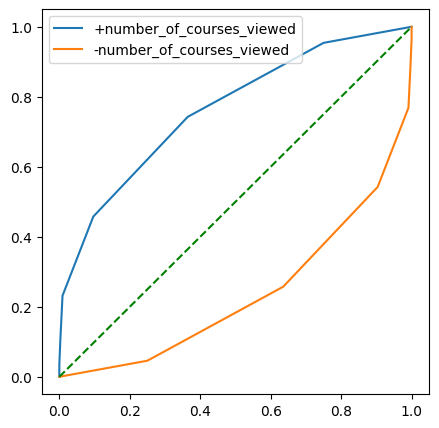

In [ ]:
# Plot the ROC curve.
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.number_of_courses_viewed)
plt.plot(fpr, tpr, label='+number_of_courses_viewed')

fpr, tpr, _ = roc_curve(y_train, -df_train.number_of_courses_viewed)
plt.plot(fpr, tpr, label='-number_of_courses_viewed')

plt.plot([0, 1], [0, 1], color='green', linestyle='--')

plt.legend()
plt.show()

#### Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)
* 0.32
* 0.52
* 0.72
* 0.92

In [ ]:
# Train a logistic regression model.
columns = numerical + categorical

dv = DictVectorizer(sparse=False)
train_dicts = df_train[columns].to_dict(orient='records')
val_dicts = df_val[columns].to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
score = roc_auc_score(y_val, y_pred)

print(round(score, 3))

0.817


#### Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?
* 0.145
* 0.345
* 0.545
* 0.745

In [ ]:
# Inspect the bin ROC AUC SCORE.
y_pred_bin = model.predict(X_val)
bin_score = roc_auc_score(y_val, y_pred_bin)
print(round(bin_score, 2))

0.65


In [ ]:
# Define confusion_matrix_dataframe function.
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores

In [ ]:
# Create the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,171,122,0,0
10,0.1,171,122,0,0
20,0.2,171,122,0,0
30,0.3,171,119,0,3
40,0.4,171,105,0,17
50,0.5,164,81,7,41
60,0.6,150,53,21,69
70,0.7,106,25,65,97
80,0.8,64,6,107,116
90,0.9,24,1,147,121


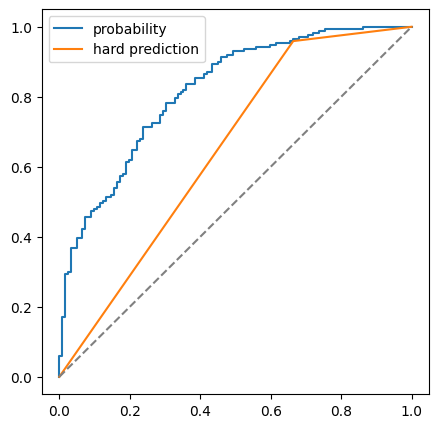

In [ ]:
# Inspecting the ROC curve.
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

In [ ]:
# Add the columns.
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

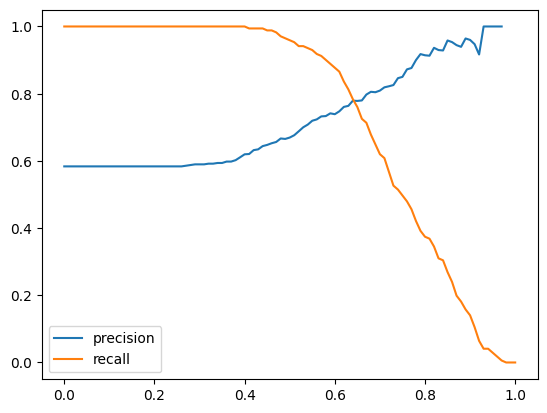

In [ ]:
#Implement the curves.
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()